In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import csv
import datetime
import pickle
import iperfDetailsParser

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

import sys
workDir = "path/to/datasets/directory"
sys.path.append(workDir + "/src/")

pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# set notebook configuration

# select visualization mode
%matplotlib inline
# %matplotlib qt

# parse the iperf_details json data which gives measurement details for each second
generateDetailedIperfCsv = False

# generate pickled dataframe with TCP DL iperf test duration information for all devices
generateIperfDurationPickle = False

# output the evenly sampled dataset to csv file
generateCombinedCsv = False

# default figure size for inline plots
defFigSize = (15, 8)


In [4]:
# read csv dataset

# UL or DL
mode = 'DL'

# TCP or UDP
protocol = 'TCP'

plotDevices = False

radioCellIdSubset = True
radioCellIds = np.array([263682.0, 271361.0], dtype=np.float64)

radioLTEBandSubset = True
radioLTEBands = ['B3']

deviceDropSubset = True
deviceHashDropSubset = '776ed8bbb94944f7f8dce18edbaa9b75aAndroid'

deviceSubset = False
# deviceHashSubset = '8b6799462ee077013b74c0cee9212f60cAndroid'

# columns used in analysis
columnSubset = ['timestamp', 'hash', 'kbps', 'radio_rsrq_db_start', 'duration']
columnSubsetSum = ['timestamp', 'kbps']

resultsFolder = "../results/"
filenameDl = workDir + "/datasets/20190426_iperf_samsung.csv"
data_iperf_raw = pd.read_csv(filepath_or_buffer=filenameDl, sep=',', decimal='.', parse_dates=['timestamp'])

# print(data_iperf_raw.info(verbose=True))


In [5]:
# basic dataset filtering
print("\nbefore filter: ", data_iperf_raw.shape)
if radioCellIdSubset:
    data_iperf_raw = data_iperf_raw.loc[data_iperf_raw.radio_cell_id_start.isin(radioCellIds)]

if radioLTEBandSubset:
    data_iperf_raw = data_iperf_raw.loc[data_iperf_raw.radio_lte_band_start.isin(radioLTEBands)]
    
if deviceDropSubset:
    data_iperf_raw = data_iperf_raw.loc[~data_iperf_raw.hash.str.contains(deviceHashDropSubset)]
    
if deviceSubset:
    data_iperf_raw = data_iperf_raw.loc[data_iperf_raw.hash.str.contains(deviceHashSubset)]


if mode == 'DL':
    print("DL analysis")
    data_iperf_raw = data_iperf_raw.loc[data_iperf_raw.direction.str.contains('DL')]
else:
    print("UL analysis")
    data_iperf_raw = data_iperf_raw.loc[data_iperf_raw.direction.str.contains('UL')]
    
if protocol == 'TCP':
    print("TCP protocol analysis")
    data_iperf_raw = data_iperf_raw.loc[data_iperf_raw.protocol.str.contains('TCP')]
else:
    print("UDP protocol analysis")
    data_iperf_raw = data_iperf_raw.loc[data_iperf_raw.protocol.str.contains('UDP')]

print("\nafter filter: ", data_iperf_raw.shape)



before filter:  (102861, 105)


DL analysis
TCP protocol analysis

after filter:  (31241, 105)


In [6]:
import multiprocessing
import time


def generate_iperf_details(input_data, test_duration=4, n_streams=4):
    # @brief iterates through dataframe, parses iperf details json and returns new dataframe containing iperf details
    # @param input_data: input dataframe
    # @param test_duration: duration of iperf tests in seconds
    # @param n_streams: number of simultaneous TCP streams used in each test 
    
    # pre-initialize the resulting dataframe
    data_iperf_extended = pd.DataFrame(index=np.arange(0, input_data.shape[0]*test_duration),
                                       columns=iperfDetailsParser.get_column_names(mode=input_data.iloc[0].direction,
                                                                                   n_streams=n_streams))
    row_iperf_extended = 0
    test_id = 0
    
    for row in input_data.itertuples(index=False):
        
        iperf_details = iperfDetailsParser.parse_iperf_details_json(hash=row[1], mode=row[2], json_string=row[3], test_id=test_id)
        row_iperf_extended_end = row_iperf_extended + iperf_details.shape[0]        
        data_iperf_extended.iloc[row_iperf_extended:row_iperf_extended_end] = iperf_details.values
        row_iperf_extended = row_iperf_extended_end
        
        test_id = test_id + 1
    
    return data_iperf_extended


if generateDetailedIperfCsv:
    
    timeStart = time.time()
    data_iperf_raw = data_iperf_raw[["timestamp", "hash", "direction", "iperf_details"]].dropna(axis="rows", how="any")
    print(data_iperf_raw.shape)
    groupedDevices = data_iperf_raw.groupby(pd.Grouper(key="hash"))
    
    deviceCandidates = [devData for _, devData in groupedDevices]

    print("number of threads:", multiprocessing.cpu_count())
    print("number of hashses:", len(groupedDevices))
    
    pool = multiprocessing.Pool()
    result = pool.map(generate_iperf_details, deviceCandidates)
    data_iperf_detailed = pd.concat(result).reset_index(drop=True)
    print("time elapsed: ", time.time() - timeStart)
    
    if data_iperf_detailed.iloc[0].direction == "UL":
        outCsv = workDir + "/datasets/iperf_samsung_detailed_ul.csv"
    else:
        outCsv = workDir + "/datasets/iperf_samsung_detailed_dl.csv"

    data_iperf_detailed.to_csv(path_or_buf=outCsv, sep=',', decimal='.', quoting=csv.QUOTE_NONNUMERIC,
                               encoding='utf-8', index=True)


In [7]:
if generateIperfDurationPickle:
    dataRsrqRelation = data_iperf_raw.loc[data_iperf_raw.timestamp > "2019-02-18 23:00:00"]
    dataRsrqRelation["iperf_test_start"] = dataRsrqRelation.timestamp - pd.Timedelta(seconds=dataRsrqRelation.duration.mean())
    
    outPickle = workDir + "/datasets/iperf_rsrq_kbps_relation.pkl"
    dataRsrqRelation[["hash", "timestamp", "iperf_test_start", "kbps", "protocol", "direction", "duration"]].to_pickle(outPickle)


In [8]:
# sateliti in CA

In [9]:
# use the specified column subset
dataColSubset = data_iperf_raw[columnSubset]
dataColSubset = dataColSubset.dropna(axis='rows', how='any')
print(dataColSubset.shape)


(30989, 5)


In [10]:
# conversion to evenly sampled time series with split-apply-combine approach
timeGroupPeriodMin = 5

# split - by measurement device hash
dataPerDevice = dataColSubset.groupby(pd.Grouper(key='hash'))


def resample_series(data, period_min, agg_fn):
    # resample each time series to the desired period
    period_min = str(period_min) + 'min'
    resampled = data.resample(period_min, on='timestamp').apply(agg_fn)
    return resampled


def merge_by_timestamp(data, agg_fn):
    # merges the matching timestamps in data with agg_fn
    return data.groupby(pd.Grouper(key='timestamp')).agg(agg_fn)
    

# apply - resample series
# combine - mean, sum
aggregatedMean = dataPerDevice.apply((lambda x: resample_series(x, timeGroupPeriodMin, 'mean'))).reset_index()
aggregatedSum = dataPerDevice[columnSubsetSum].apply((lambda x: resample_series(x, timeGroupPeriodMin, 'sum'))).reset_index()

outMean = merge_by_timestamp(aggregatedMean, 'mean')
outSum = merge_by_timestamp(aggregatedSum, 'sum')

# merge the combined datasets into one
data_out = outMean.merge(outSum, how='left', on='timestamp')
data_out = data_out.rename(columns={'kbps_x': 'kbps_mean',
                                    'kbps_y': 'kbps_sum'})
data_out = data_out.dropna(axis="rows", how="any")

print(data_out.shape)

(4511, 4)


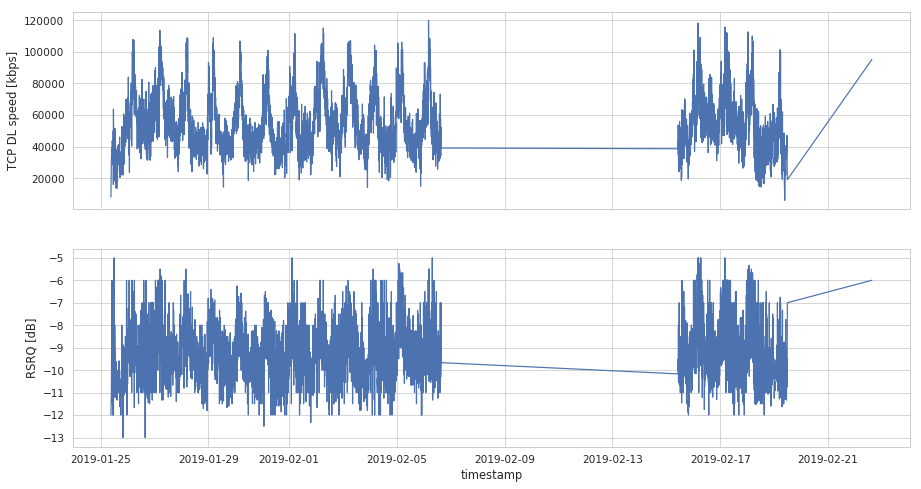

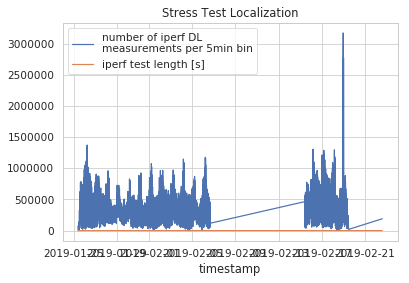

In [11]:
# combined dataset visualization
plt.close("all")

fig, axes = plt.subplots(figsize=defFigSize, nrows=2, ncols=1, sharex='all', squeeze=True)
axes[0].plot(data_out[['kbps_mean']])
axes[0].set_ylabel("TCP " + mode + " speed [kbps]")

axes[1].plot(data_out[['radio_rsrq_db_start']])
axes[1].set_ylabel("RSRQ [dB]")

axes[1].set_xlabel("timestamp")

fig, ax1 = plt.subplots()
plt.title("Stress Test Localization")
ax1.plot(data_out[['kbps_sum']], label="number of iperf DL\nmeasurements per " + str(timeGroupPeriodMin) + "min bin")
ax1.set_xlabel("timestamp")
ax1.plot(data_out.duration, label="iperf test length [s]")
ax1.legend()

In [12]:
# combined dataset export to csv
if generateCombinedCsv:
    outCsv = workDir + "/datasets/iperf_samsung_combined.csv"
    data_out.to_csv(path_or_buf=outCsv, sep=',', decimal='.', quoting=csv.QUOTE_NONNUMERIC,
                    encoding='utf-8', index=True)


In [13]:
# STRESS TEST ANALYSIS
# compute the representative segment

# select the hh:mm of stress test in whole dataset for comparison
nightPeriodStart = datetime.time(21, 00, 00)
nightPeriodStop = datetime.time(00, 29, 00)

dtFormat = '%Y%m%d %H:%M:%S'
stresTestStart = pd.to_datetime("20190218 " + str(nightPeriodStart), format=dtFormat)
stressTestStop = pd.to_datetime("20190219 " + str(nightPeriodStop), format=dtFormat)

# select the stress test time period and filter out the actual stress test data
dataNightPeriod = data_out.between_time(nightPeriodStart, nightPeriodStop, include_start=True, include_end=True)
dataNightPeriod = dataNightPeriod.loc[(dataNightPeriod.index < stresTestStart)]

# select only business day data
dataNightPeriod = dataNightPeriod[dataNightPeriod.index.dayofweek < 5]

# compute the representative segment
periodRepresentative = dataNightPeriod.groupby([dataNightPeriod.index.hour, dataNightPeriod.index.minute]).mean()
periodRepresentativeStd = dataNightPeriod.groupby([dataNightPeriod.index.hour, dataNightPeriod.index.minute]).std()

# generate new datetime index for the segment
periodRepresentative.index.names = ['hour', 'min']
periodRepresentativeStd.index.names = ['hour', 'min']
idxNew = []

for idx, row in periodRepresentative.iterrows():
    hh, min = idx
    
    time = str(hh) + ':' + str(min) + ':00'
    if hh < nightPeriodStart.hour:
        dt = pd.to_datetime('20190219 ' + time, format=dtFormat) 
    else:
        dt = pd.to_datetime('20190218 ' + time, format=dtFormat) 

    idxNew.append(dt)

periodRepresentative = periodRepresentative.reset_index()
periodRepresentative.index = idxNew
periodRepresentative = periodRepresentative.sort_index()

periodRepresentativeStd = periodRepresentativeStd.reset_index()
periodRepresentativeStd.index = idxNew
periodRepresentativeStd = periodRepresentativeStd.sort_index()

# stress test segment
periodStressTest = data_out[stresTestStart:stressTestStop]


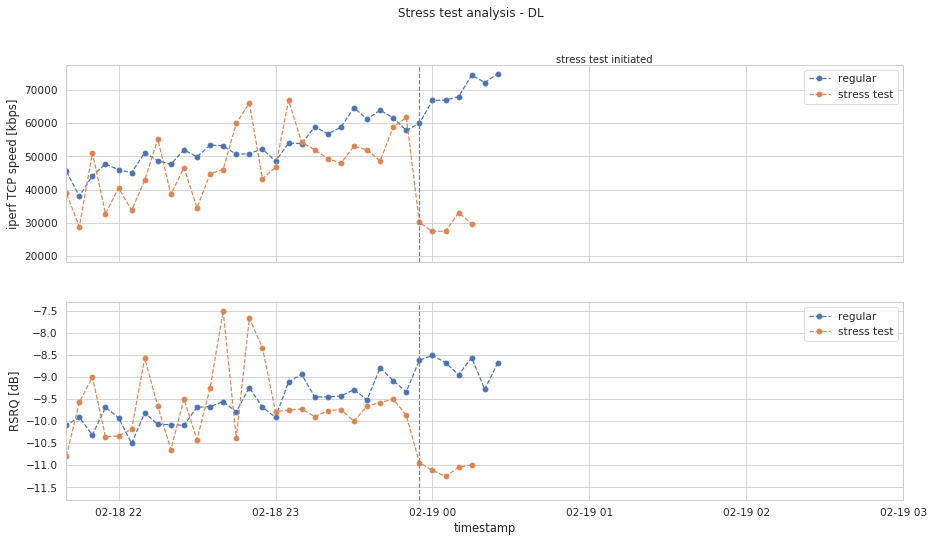

In [25]:
# stress test segment visualization
plt.close("all")

fig, axes = plt.subplots(nrows=2, ncols=1, sharex='all', squeeze=True, figsize=defFigSize)
fig.suptitle("Stress test analysis - " + mode)


axes[0].plot(periodRepresentative.kbps_mean, marker='o', ls='--', label='regular')
axes[0].plot(periodStressTest.kbps_mean, marker='o', ls='--', label='stress test')
axes[0].axvline("2019-02-18 23:55:00", ls='--', color="gray")

axes[0].set_xlim("2019-02-18 21:40:00", "2019-02-19 03:00:00")
axes[0].set_ylabel("iperf TCP speed [kbps]")
axes[0].legend(loc='upper right')

top = 1
axes[0].text(0.7, top, "stress test initiated",
             horizontalalignment='right',
             verticalalignment='bottom',
             transform=axes[0].transAxes)

axes[1].plot(periodRepresentative.radio_rsrq_db_start, marker='o', ls='--', label="regular")
axes[1].plot(periodStressTest.radio_rsrq_db_start, marker='o', ls='--', label="stress test")
axes[1].axvline("2019-02-18 23:55:00", ls='--', color="gray")

axes[1].set_ylabel("RSRQ [dB]")
axes[1].set_xlabel("timestamp")
axes[1].legend(loc='upper right')



quantiles normal:  0.25    61827.553571
0.50    67435.700000
0.75    75540.581591
Name: kbps_mean, dtype: float64
43030.637500000004
(114, 4)

quantiles stress:  0.25    27506.875263
0.50    29777.748333
0.75    30161.088396
Name: kbps_mean, dtype: float64
33074.081296296295
(5, 4)

quantiles normal:  0.25   -9.592857
0.50   -9.000000
0.75   -8.143750
Name: radio_rsrq_db_start, dtype: float64
-11.4

quantiles stress:  0.25   -11.113158
0.50   -11.048148
0.75   -10.985185
Name: radio_rsrq_db_start, dtype: float64
-10.940852130325815


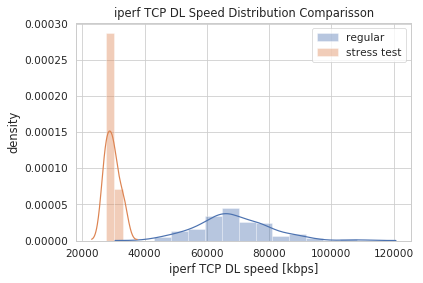

In [15]:
# stress test to representative segment data distribution comparison
distPeriodStart = datetime.time(23, 50, 00)
distPeriodStop = datetime.time(00, 29, 00)

distDataNormal = data_out.between_time(distPeriodStart, distPeriodStop, include_start=True, include_end=True)
distDataNormal = distDataNormal.loc[distDataNormal.index < stresTestStart]

plt.close("all")
plt.figure()

plt.title("iperf TCP " + mode + " Speed Distribution Comparisson")
sns.distplot(distDataNormal.kbps_mean, norm_hist=True, kde=True, label="regular")

distDataStress = data_out["2019-02-18 23:55:00": "2019-02-19 00:29:00"]
sns.distplot(distDataStress.kbps_mean, norm_hist=True, kde=True, label="stress test")

plt.xlabel("iperf TCP " + mode + " speed [kbps]")
plt.ylabel("density")

plt.legend()

# display some stats
print("\nquantiles normal: ", distDataNormal.kbps_mean.quantile([0.25, 0.5, 0.75]))
print(distDataNormal.kbps_mean.min())
print(distDataNormal.shape)

print("\nquantiles stress: ", distDataStress.kbps_mean.quantile([0.25, 0.5, 0.75]))
print(distDataStress.kbps_mean.max())
print(distDataStress.shape)


print("\nquantiles normal: ", distDataNormal.radio_rsrq_db_start.quantile([0.25, 0.5, 0.75]))
print(distDataNormal.radio_rsrq_db_start.min())

print("\nquantiles stress: ", distDataStress.radio_rsrq_db_start.quantile([0.25, 0.5, 0.75]))
print(distDataStress.radio_rsrq_db_start.max())


In [16]:
# SEASONAL COMPONENT ANALYSIS
whichSeries = "kbps"
analyseBusinessWeek = False

timestampDivideSegment = "2019-02-09 00:00:00"
timestampWorkWeekStart = "2019-01-28 00:00:00"
timestampWorkWeekStop = "2019-02-02 00:00:00"

if whichSeries == "kbps":
    dataSeasonal = data_out.kbps_mean[:timestampDivideSegment]
else:
    dataSeasonal = data_out.radio_rsrq_db_start[:timestampDivideSegment]
    
if analyseBusinessWeek:
    dataSeasonal = dataSeasonal[timestampWorkWeekStart:timestampWorkWeekStop]

print(dataSeasonal.head())

timestamp
2019-01-25 09:15:00     8176.10
2019-01-25 09:40:00    32001.70
2019-01-25 10:10:00    39373.85
2019-01-25 10:20:00    35840.90
2019-01-25 10:25:00    43658.70
Name: kbps_mean, dtype: float64


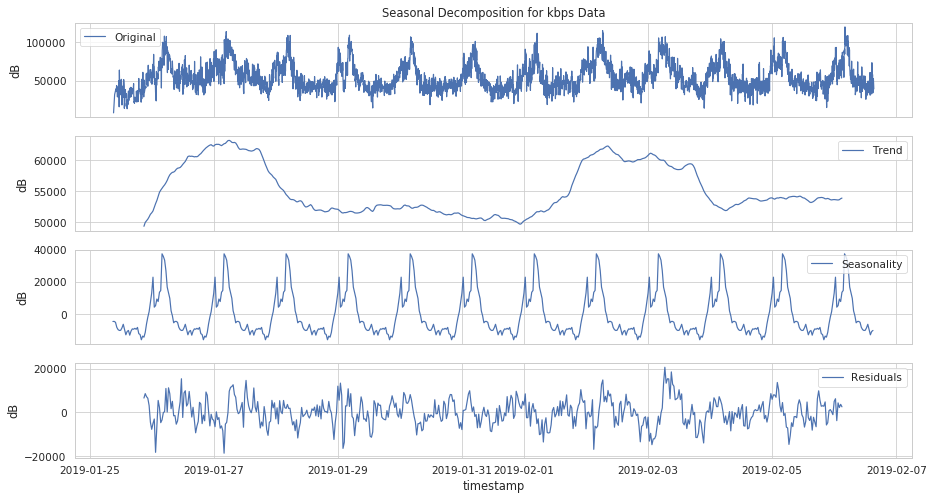

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal decomposition
dataDecompose = dataSeasonal.resample('30min').mean().dropna()

decomposition = seasonal_decompose(dataDecompose, model="add", freq=48)

ts_trend = decomposition.trend
ts_seasonal = decomposition.seasonal
ts_residual = decomposition.resid

plt.close("all")
fig, axes = plt.subplots(figsize=defFigSize, nrows=4, ncols=1, sharex='all', squeeze=True)
axes[0].set_title("Seasonal Decomposition for " + whichSeries + " Data")
axes[0].plot(dataSeasonal, label='Original')
axes[0].set_ylabel("dB")
axes[0].legend()

axes[1].plot(ts_trend, label='Trend')
axes[1].set_ylabel("dB")
axes[1].legend()

axes[2].plot(ts_seasonal, label='Seasonality')
axes[2].set_ylabel("dB")
axes[2].legend()

axes[3].plot(ts_residual, label='Residuals')
axes[3].set_ylabel("dB")
axes[3].set_xlabel("timestamp")
axes[3].legend(loc="upper right")

decompositionResidual = ts_residual.dropna()


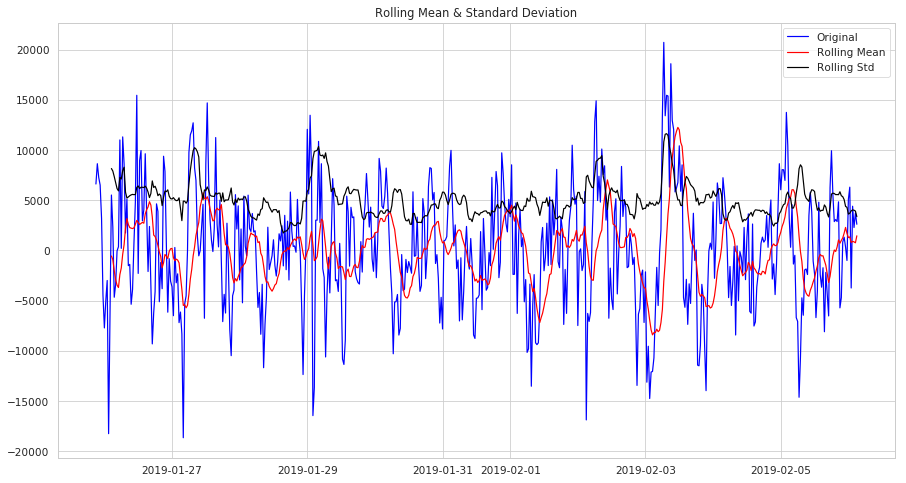

Results of Dickey-Fuller Test:
Test Statistic         -9.605028e+00
p-value                 1.876143e-16
                            ...     
Critical Value (5%)    -2.866917e+00
Critical Value (10%)   -2.569634e+00
Length: 7, dtype: float64
Hurst's parameter:  0.008144021174469288


In [22]:
import tsAnalyse as ta

# analyze the resisual time series properties
ta.test_stationarity(decompositionResidual, defFigSize)
hurst = ta.hurst(decompositionResidual)
print("Hurst's parameter: ", hurst)


443


<StemContainer object of 3 artists>

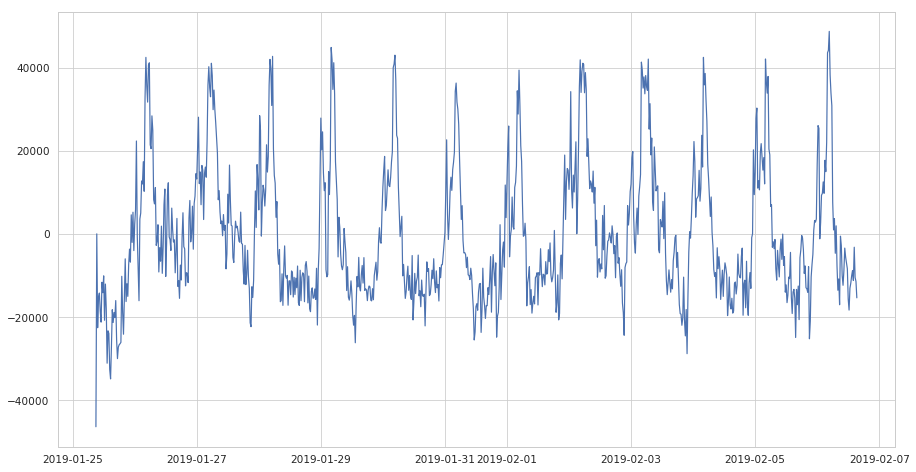

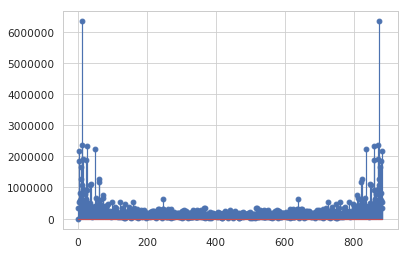

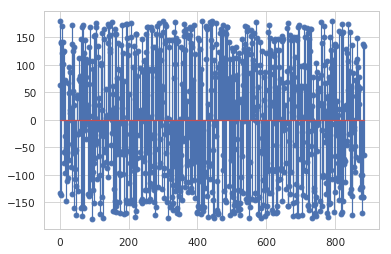

In [24]:
# analze seasonality with FFT
plt.close("all")

ts = dataSeasonal[timestampWorkWeekStart:timestampWorkWeekStop].resample("30min")\
    .apply("mean").fillna(dataSeasonal.mean())

fftMode = "fullWeek"

if fftMode == "fullWeek":
    ts = dataSeasonal.resample("20min").apply("mean")\
         .fillna(dataSeasonal.mean())
else:
    ts = dataSeasonal[timestampWorkWeekStart:timestampWorkWeekStop].resample("20min").apply("mean")\
         .fillna(dataSeasonal.mean())

ts = ts - ts.mean()

ts_fourier = np.abs(np.fft.rfft(ts))**2
print(len(ts_fourier))
spectrum = np.fft.fft(ts)

# sampling frequency [samples/hour]
fs = 3
freq = np.fft.fftfreq(len(ts), d=fs)
amp = np.abs(spectrum)
phase = np.angle(spectrum, deg=True)

plt.close("all")
plt.figure(figsize=defFigSize)
plt.plot(ts)

plt.figure()
plt.stem(amp)

plt.figure()
plt.stem(phase)

